In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy.io
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import os

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Conv2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

c:\Users\ryang\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
label=pd.read_csv('Forest Segmented\meta_data.csv')

classes = {
    '0': (0, 0, 0,),
    '1': (255, 255, 255)
}

print(label)

path_original_images = 'Forest Segmented/images'
path_label_images = 'Forest Segmented/masks'
num_class = 2

print(num_class)

                  image                mask
0      10452_sat_08.jpg   10452_mask_08.jpg
1      10452_sat_18.jpg   10452_mask_18.jpg
2     111335_sat_00.jpg  111335_mask_00.jpg
3     111335_sat_01.jpg  111335_mask_01.jpg
4     111335_sat_02.jpg  111335_mask_02.jpg
...                 ...                 ...
5103  998002_sat_31.jpg  998002_mask_31.jpg
5104  998002_sat_32.jpg  998002_mask_32.jpg
5105  998002_sat_40.jpg  998002_mask_40.jpg
5106  998002_sat_41.jpg  998002_mask_41.jpg
5107  998002_sat_50.jpg  998002_mask_50.jpg

[5108 rows x 2 columns]
2


In [4]:
def shuffle(arr1, arr2):
    randomize = np.arange(len(arr1))
    np.random.shuffle(randomize)
    return arr1[randomize], arr2[randomize]

In [5]:
img, msk = label.items()
image, mask = shuffle(np.array(img[1]), np.array(msk[1]))
print(image)
print(mask)

['688544_sat_67.jpg' '498049_sat_60.jpg' '255876_sat_57.jpg' ...
 '810749_sat_71.jpg' '143794_sat_36.jpg' '345134_sat_15.jpg']
['688544_mask_67.jpg' '498049_mask_60.jpg' '255876_mask_57.jpg' ...
 '810749_mask_71.jpg' '143794_mask_36.jpg' '345134_mask_15.jpg']


In [6]:
def get_original_images():
    temp_img = []
    for a in range(image.shape[0]):
        temp_img.append(tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(f"{path_original_images}/{image[a]}", target_size=(128,128))))
    
    return np.array(temp_img)

In [7]:
def get_mod_images(mod_path):
    temp_img = []
    for a in range(image.shape[0]):
        temp_img.append(tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(f"{mod_path}/{image[a]}", target_size=(128,128))))
    
    return np.array(temp_img)

In [8]:
def classconvert():
    rtn = []
    for a in range(mask.shape[0]):
        img_mask = tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(f"{path_label_images}/{mask[a]}", target_size=(128,128)))
        temp_mask = np.zeros(shape=(img_mask.shape[0], img_mask.shape[1]), dtype = np.uint32)

        for row in range(img_mask.shape[0]):
            for col in range(img_mask.shape[1]):
                if img_mask[row, col, 0] > 128:
                    temp_mask[row, col] = 1
        temp_mask = np.reshape(temp_mask, (temp_mask.shape[0], temp_mask.shape[1], 1))
        rtn.append(temp_mask)
    return np.array(rtn)

In [9]:
def normalize(n):
    return n/255.0

In [10]:
x = normalize(np.load('x_v2.npy'))
y = np.load('y_v2.npy')

x_train = x[0:4086]
y_train = y[0:4086]
x_val = x[4086:5180]
y_val = y[4086:5180]

edge = normalize(np.load("edge_v2.npy"))
hist = normalize(np.load("hist_v2.npy"))
edge_hist = normalize(np.load("edge_hist_v2.npy"))

dataset_edge = edge[0:4086]
dataset_hist = hist[0:4086]
dataset_edge_hist = edge_hist[0:4086]

dataset_edge_val = edge[4086:5180]
dataset_hist_val = hist[4086:5180]
dataset_edge_hist_val = edge_hist[4086:5180]

dataset_noise = normalize(np.load("dataset_noise_v2.npy"))
dataset_edge_noise = normalize(np.load("dataset_edge_noise_v2.npy"))
dataset_hist_noise = normalize(np.load("dataset_hist_noise_v2.npy"))
dataset_all = normalize(np.load("dataset_all_v2.npy"))

dataset_noise_val = x[4086:5180]
dataset_edge_noise_val = edge[4086:5180]
dataset_hist_noise_val = hist[4086:5180]
dataset_all_val = edge_hist[4086:5180]

In [11]:
def output_to_image(out_img):
    img = np.zeros(shape=(out_img.shape[0], out_img.shape[1], 1), dtype = np.uint32)
    for row in range(out_img.shape[0]):
        for col in range(out_img.shape[1]):
            img[row,col,:] = np.array(0 if out_img[row,col] < 0.5 else 1)
    return img

In [43]:
def conv(input, n):
  x = keras.layers.Conv2D(n, 3, padding='same', activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Conv2D(n, 3, padding='same', activation='relu')(x)

  return x

In [44]:
def encoder(input, n, drop):
  x = conv(input, n)
  if drop > 0.0:
    c = keras.layers.Dropout(drop)(x)
    c = keras.layers.MaxPooling2D(pool_size=(2,2))(c)
  else:
    c = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
  return x, c

In [45]:
def decoder(input, concat, n):
  x = keras.layers.Conv2DTranspose(n, (2,2), strides=2, padding='same')(input)
  x = keras.layers.Concatenate()([x, concat])
  x = conv(x, n)
  return x

In [46]:
def build_unet(input_shape, drop):
    inputs = keras.layers.Input(input_shape)

    s1, p1 = encoder(inputs, 64, drop)
    s2, p2 = encoder(p1, 128, drop)
    s3, p3 = encoder(p2, 256, drop)
    s4, p4 = encoder(p3, 512, drop)

    b1 = conv(p4, 1024)

    d1 = decoder(b1, s4, 512)
    d2 = decoder(d1, s3, 256)
    d3 = decoder(d2, s2, 128)
    d4 = decoder(d3, s1, 64)

    outputs = Conv2D(num_class, kernel_size=(3,3), strides=1, padding="same", activation="sigmoid")(d4)

    model = keras.Model(inputs=[inputs], outputs=[outputs], name="U-Net")
    return model

In [50]:
def build_unet7(input_shape, drop):
    inputs = keras.layers.Input(input_shape)

    s1, p1 = encoder(inputs, 16, drop)
    s2, p2 = encoder(p1, 32, drop)
    s3, p3 = encoder(p2, 64, drop)
    s4, p4 = encoder(p3, 128, drop)
    s5, p5 = encoder(p4, 256, drop)
    s6, p6 = encoder(p5, 512, drop)

    b1 = conv(p6, 1024)

    d1 = decoder(b1, s6, 512)
    d2 = decoder(d1, s5, 256)
    d3 = decoder(d2, s4, 128)
    d4 = decoder(d3, s3, 64)
    d5 = decoder(d4, s2, 32)
    d6 = decoder(d5, s1, 16)

    outputs = Conv2D(num_class, kernel_size=(3,3), strides=1, padding="same", activation="sigmoid")(d6)

    model = keras.Model(inputs=[inputs], outputs=[outputs], name="U-Net")
    return model

In [56]:
# Function to calculate Intersection over Union (IoU)
def calculate_iou(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Function to calculate Mean Intersection over Union (mIoU)
def calculate_miou(y_true, y_pred, smooth=1):
    iou_foreground = calculate_iou(y_true, y_pred, smooth)
    iou_background = calculate_iou(1 - y_true, 1 - y_pred, smooth)
    miou = (iou_foreground + iou_background) / 2
    return miou

# Function to calculate Dice Coefficient
def calculate_dice(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

# Custom metric for mIoU
def mean_iou(y_true, y_pred):
    return calculate_miou(y_true, tf.round(y_pred))

# Custom metric for Dice Coefficient
def dice_coef(y_true, y_pred):
    return calculate_dice(y_true, tf.round(y_pred))

In [57]:
dependencies = {
    'mean_iou': mean_iou,
    'dice_coef': dice_coef
}

In [59]:
model_unet = keras.models.load_model("unet_saved_models/10/unet_100_epoch_force.h5", custom_objects=dependencies)
model_unet_n = keras.models.load_model("unet_saved_models/10/noise_100_epoch_force.h5", custom_objects=dependencies)
model_unet_e = keras.models.load_model("unet_saved_models/10/edge_100_epoch_force.h5", custom_objects=dependencies)
model_unet_h = keras.models.load_model("unet_saved_models/10/hist_100_epoch_force.h5", custom_objects=dependencies)
model_unet_ne = keras.models.load_model("unet_saved_models/10/edge_noise_100_epoch_force.h5", custom_objects=dependencies)
model_unet_nh = keras.models.load_model("unet_saved_models/10/noise_hist_100_epoch_force.h5", custom_objects=dependencies)
model_unet_eh = keras.models.load_model("unet_saved_models/10/edge_hist_100_epoch_force.h5", custom_objects=dependencies)
model_unet_all = keras.models.load_model("unet_saved_models/10/all_100_epoch_force.h5", custom_objects=dependencies)

model_unet7 = keras.models.load_model("unet7_saved_models/10/unet7_100_epoch_force.h5", custom_objects=dependencies)
model_unet7_n = keras.models.load_model("unet7_saved_models/10/noise_100_epoch_force.h5", custom_objects=dependencies)
model_unet7_e = keras.models.load_model("unet7_saved_models/10/edge_100_epoch_force.h5", custom_objects=dependencies)
model_unet7_h = keras.models.load_model("unet7_saved_models/10/hist_100_epoch_force.h5", custom_objects=dependencies)
model_unet7_ne = keras.models.load_model("unet7_saved_models/10/noise_edge_100_epoch_force.h5", custom_objects=dependencies)
model_unet7_nh = keras.models.load_model("unet7_saved_models/10/noise_hist_100_epoch_force.h5", custom_objects=dependencies)
model_unet7_eh = keras.models.load_model("unet7_saved_models/10/edge_hist_100_epoch_force.h5", custom_objects=dependencies)
model_unet7_all = keras.models.load_model("unet7_saved_models/10/all_100_epoch_force.h5", custom_objects=dependencies)

In [60]:
model_unet.load_weights('checkpoint/10/model_unet/model_unet_0048_0.5081_0.8303_0.6936_0.8652_.h5')
model_unet_n.load_weights('checkpoint/10/model_unet_noise/model_unet_0028_0.4392_0.8195_0.6750_0.8578_.h5')
model_unet_e.load_weights('checkpoint/10/model_unet_edge/model_unet_0040_0.5143_0.8127_0.6647_0.8531_.h5')
model_unet_h.load_weights('checkpoint/10/model_unet_hist/model_unet_0049_0.5244_0.8233_0.6819_0.8602_.h5')
model_unet_ne.load_weights('checkpoint/10/model_unet_noise_edge/model_unet_0012_0.4191_0.8212_0.6792_0.8580_.h5')
model_unet_nh.load_weights('checkpoint/10/model_unet_noise_hist/model_unet_0026_0.4091_0.8272_0.6896_0.8610_.h5')
model_unet_eh.load_weights('checkpoint/10/model_unet_edge_hist/model_unet_0015_0.4306_0.8119_0.6633_0.8525_.h5')
model_unet_all.load_weights('checkpoint/10/model_unet_all/model_unet_0040_0.4841_0.8116_0.6630_0.8533_.h5')

model_unet7.load_weights('checkpoint/10/model_unet7/model_unet7_0031_0.4306_0.8158_0.6620_0.8608_.h5')
model_unet7_n.load_weights('checkpoint/10/model_unet7_noise/model_unet_0046_0.4563_0.8211_0.6734_0.8624_.h5')
model_unet7_e.load_weights('checkpoint/10/model_unet7_edge/model_unet_0043_0.4607_0.8217_0.6762_0.8619_.h5')
model_unet7_h.load_weights('checkpoint/10/model_unet7_hist/model_unet_0024_0.4097_0.8172_0.6679_0.8592_.h5')
model_unet7_ne.load_weights('checkpoint/10/model_unet7_noise_edge/model_unet_0038_0.4412_0.8190_0.6727_0.8597_.h5')
model_unet7_nh.load_weights('checkpoint/10/model_unet7_noise_hist/model_unet_0014_0.4636_0.8068_0.6494_0.8540_.h5')
model_unet7_eh.load_weights('checkpoint/10/model_unet7_edge_hist/model_unet_0027_0.4777_0.8072_0.6511_0.8527_.h5')
model_unet7_all.load_weights('checkpoint/10/model_unet7_all/model_unet_0033_0.4777_0.8064_0.6484_0.8538_.h5')

In [102]:
randomIndex = np.random.randint(0,4000)

default = x_train[randomIndex]
n = dataset_noise[randomIndex]
e = dataset_edge[randomIndex]
h = dataset_hist[randomIndex]
ne = dataset_edge_noise[randomIndex]
nh = dataset_hist_noise[randomIndex]
eh = dataset_edge_hist[randomIndex]
a = dataset_all[randomIndex]

default = default.reshape(1,128,128,3)
n = n.reshape(1,128,128,3)
e = e.reshape(1,128,128,3)
h = h.reshape(1,128,128,3)
ne = ne.reshape(1,128,128,3)
nh = nh.reshape(1,128,128,3)
eh = eh.reshape(1,128,128,3)
a = a.reshape(1,128,128,3)

model_unet_p = model_unet.predict(default)
model_unet_n_p = model_unet_n.predict(n)
model_unet_e_p = model_unet_e.predict(e)
model_unet_h_p = model_unet_h.predict(h)
model_unet_ne_p = model_unet_ne.predict(ne)
model_unet_nh_p = model_unet_nh.predict(nh)
model_unet_eh_p = model_unet_eh.predict(eh)
model_unet_all_p = model_unet_all.predict(a)

model_unet7_p = model_unet7.predict(default)
model_unet7_n_p = model_unet7_n.predict(n)
model_unet7_e_p = model_unet7_e.predict(e)
model_unet7_h_p = model_unet7_h.predict(h)
model_unet7_ne_p = model_unet7_ne.predict(ne)
model_unet7_nh_p = model_unet7_nh.predict(nh)
model_unet7_eh_p = model_unet7_eh.predict(eh)
model_unet7_all_p = model_unet7_all.predict(a)

1/1 [==============================] - 0s 14ms/step


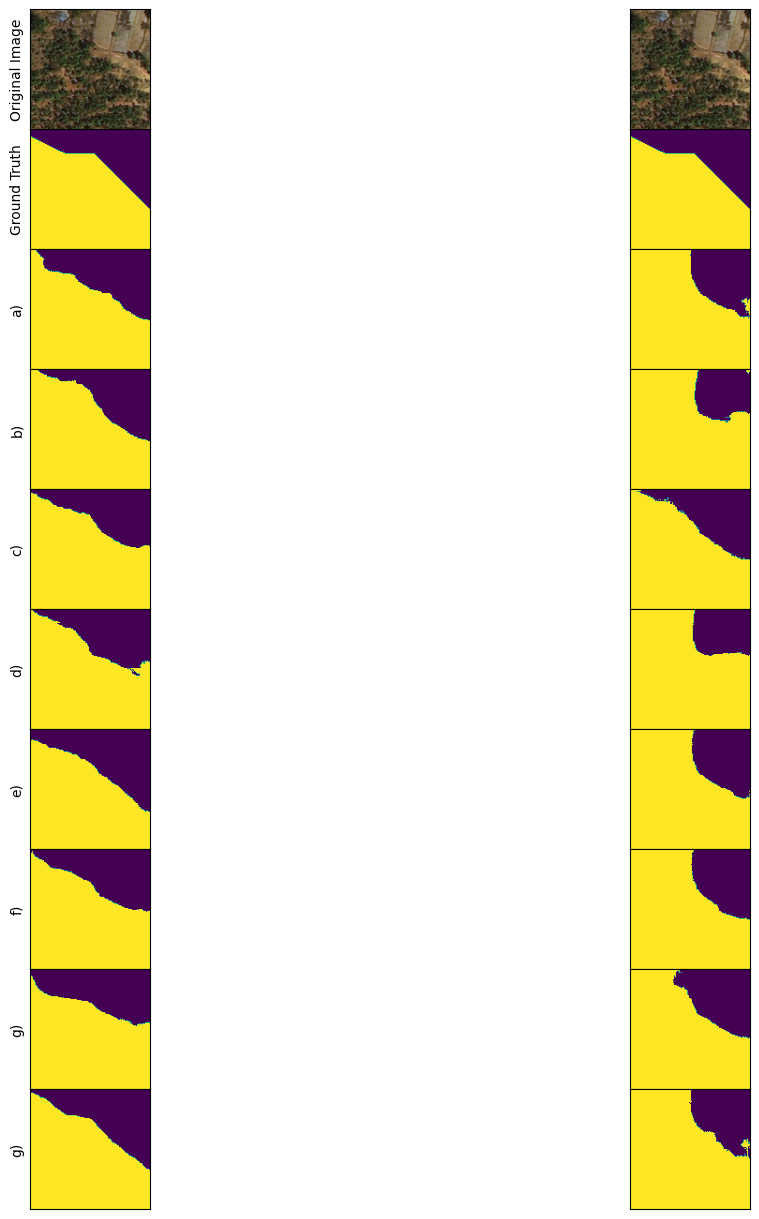

In [103]:
fig, axs = plt.subplots(10, 2, figsize=(12,12))

gs = gridspec.GridSpec(10, 2, width_ratios=[1, 1], wspace=0.1, hspace=0.1, top=0.95, bottom=0.05, left=0.17, right=0.845) 

#original images
axs[0, 0].imshow((x[randomIndex]*255).astype("uint8"))
axs[0, 1].imshow((x[randomIndex]*255).astype("uint8"))
axs[0, 0].set(ylabel='Original Image')

#ground truth
axs[1, 0].imshow(output_to_image(y[randomIndex]).astype("uint8"))
axs[1, 1].imshow(output_to_image(y[randomIndex]).astype("uint8"))
axs[1, 0].set(ylabel='Ground Truth')

#model predictions
axs[2, 0].imshow(output_to_image(model_unet_p[len(model_unet_p)-1]).astype("uint8"))
axs[2, 1].imshow(output_to_image(model_unet7_p[len(model_unet7_p)-1]).astype("uint8"))
axs[2, 0].set(ylabel='a)')

axs[3, 0].imshow(output_to_image(model_unet_n_p[len(model_unet_n_p)-1]).astype("uint8"))
axs[3, 1].imshow(output_to_image(model_unet7_n_p[len(model_unet7_n_p)-1]).astype("uint8"))
axs[3, 0].set(ylabel='b)')

axs[4, 0].imshow(output_to_image(model_unet_e_p[len(model_unet_e_p)-1]).astype("uint8"))
axs[4, 1].imshow(output_to_image(model_unet7_e_p[len(model_unet7_e_p)-1]).astype("uint8"))
axs[4, 0].set(ylabel='c)')

axs[5, 0].imshow(output_to_image(model_unet_h_p[len(model_unet_h_p)-1]).astype("uint8"))
axs[5, 1].imshow(output_to_image(model_unet7_h_p[len(model_unet7_h_p)-1]).astype("uint8"))
axs[5, 0].set(ylabel='d)')

axs[6, 0].imshow(output_to_image(model_unet_ne_p[len(model_unet_ne_p)-1]).astype("uint8"))
axs[6, 1].imshow(output_to_image(model_unet7_ne_p[len(model_unet7_ne_p)-1]).astype("uint8"))
axs[6, 0].set(ylabel='e)')

axs[7, 0].imshow(output_to_image(model_unet_nh_p[len(model_unet_nh_p)-1]).astype("uint8"))
axs[7, 1].imshow(output_to_image(model_unet7_nh_p[len(model_unet7_nh_p)-1]).astype("uint8"))
axs[7, 0].set(ylabel='f)')

axs[8, 0].imshow(output_to_image(model_unet_eh_p[len(model_unet_eh_p)-1]).astype("uint8"))
axs[8, 1].imshow(output_to_image(model_unet7_eh_p[len(model_unet7_eh_p)-1]).astype("uint8"))
axs[8, 0].set(ylabel='g)')

axs[9, 0].imshow(output_to_image(model_unet_all_p[len(model_unet_all_p)-1]).astype("uint8"))
axs[9, 1].imshow(output_to_image(model_unet7_all_p[len(model_unet7_all_p)-1]).astype("uint8"))
axs[9, 0].set(ylabel='g)')

for i in range(0,10):
    for j in range(0,2):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

In [132]:
data_dc = []
data_miou = []

results_1 = np.load("history/1/unet_history.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet_history.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet_history.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet_history.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet_history.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet_history.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet_history.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet_history.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet_history.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet_history.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Default")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet_history_n.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet_history_n.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet_history_n.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet_history_n.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet_history_n.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet_history_n.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet_history_n.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet_history_n.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet_history_n.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet_history_n.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Gaussian Noise")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet_history_e.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet_history_e.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet_history_e.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet_history_e.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet_history_e.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet_history_e.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet_history_e.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet_history_e.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet_history_e.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet_history_e.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Edge Enhancement")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet_history_h.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet_history_h.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet_history_h.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet_history_h.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet_history_h.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet_history_h.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet_history_h.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet_history_h.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet_history_h.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet_history_h.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Histogram Normalization")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet_history_ne.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet_history_ne.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet_history_ne.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet_history_ne.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet_history_ne.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet_history_ne.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet_history_ne.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet_history_ne.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet_history_ne.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet_history_ne.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Noise + Edge")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet_history_nh.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet_history_nh.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet_history_nh.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet_history_nh.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet_history_nh.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet_history_nh.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet_history_nh.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet_history_nh.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet_history_nh.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet_history_nh.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Noise + Histogram")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet_history_eh.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet_history_eh.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet_history_eh.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet_history_eh.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet_history_eh.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet_history_eh.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet_history_eh.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet_history_eh.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet_history_eh.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet_history_eh.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Edge + Histogram")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet_history_all.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet_history_all.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet_history_all.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet_history_all.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet_history_all.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet_history_all.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet_history_all.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet_history_all.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet_history_all.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet_history_all.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("ALL")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

df = pd.DataFrame(np.array(data_dc))
df.to_csv('plots/UNet_Dice.csv', index=False)

df = pd.DataFrame(np.array(data_miou))
df.to_csv('plots/UNet_mIoU.csv', index=False)

Default
UNet Dice:  [0.86428219 0.8644163  0.86264467 0.86364585 0.86349678 0.86369133
 0.86700982 0.86222965 0.86134988 0.86516911]
UNet Dice STD:  0.0015073388925555217
UNet mIoU:  [0.69203281 0.6808151  0.6979183  0.6985569  0.68421233 0.6958968
 0.68878907 0.68663174 0.69795591 0.69364333]
UNet mIoU STD:  0.005958172375215771
------------------------------------
Gaussian Noise
UNet Dice:  [0.86672586 0.86313987 0.86344939 0.86415035 0.86292982 0.86353034
 0.8603245  0.8621015  0.86275816 0.8577863 ]
UNet Dice STD:  0.0022350926601247016
UNet mIoU:  [0.68972892 0.68410987 0.67941749 0.69824952 0.69266891 0.69679075
 0.68590486 0.68346119 0.69035006 0.68155777]
UNet mIoU STD:  0.006061555070977127
------------------------------------
Edge Enhancement
UNet Dice:  [0.85942656 0.86434811 0.86128771 0.85907841 0.85945201 0.85642684
 0.85761303 0.86018652 0.85899252 0.85306096]
UNet Dice STD:  0.002818717391903882
UNet mIoU:  [0.68159026 0.69248652 0.68388098 0.68100089 0.68755919 0.68237

In [129]:
data_dc = []
data_miou = []

results_1 = np.load("history/1/unet7_history.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet7_history.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet7_history.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet7_history.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet7_history.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet7_history.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet7_history.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet7_history.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet7_history.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet7_history.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Default")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet7_history_n.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet7_history_n.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet7_history_n.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet7_history_n.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet7_history_n.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet7_history_n.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet7_history_n.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet7_history_n.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet7_history_n.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet7_history_n.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Gaussian Noise")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet7_history_e.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet7_history_e.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet7_history_e.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet7_history_e.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet7_history_e.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet7_history_e.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet7_history_e.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet7_history_e.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet7_history_e.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet7_history_e.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Edge Enhancement")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet7_history_h.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet7_history_h.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet7_history_h.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet7_history_h.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet7_history_h.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet7_history_h.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet7_history_h.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet7_history_h.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet7_history_h.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet7_history_h.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Histogram Normalization")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet7_history_ne.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet7_history_ne.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Noise + Edge")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet7_history_nh.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet7_history_nh.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Noise + Histogram")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet7_history_eh.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet7_history_eh.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("Edge + Histogram")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

results_1 = np.load("history/1/unet7_history_all.npy", allow_pickle='TRUE').item()
results_2 = np.load("history/2/unet7_history_all.npy", allow_pickle='TRUE').item()
results_3 = np.load("history/3/unet7_history_all.npy", allow_pickle='TRUE').item()
results_4 = np.load("history/4/unet7_history_all.npy", allow_pickle='TRUE').item()
results_5 = np.load("history/5/unet7_history_all.npy", allow_pickle='TRUE').item()
results_6 = np.load("history/6/unet7_history_all.npy", allow_pickle='TRUE').item()
results_7 = np.load("history/7/unet7_history_all.npy", allow_pickle='TRUE').item()
results_8 = np.load("history/8/unet7_history_all.npy", allow_pickle='TRUE').item()
results_9 = np.load("history/9/unet7_history_all.npy", allow_pickle='TRUE').item()
results_0 = np.load("history/10/unet7_history_all.npy", allow_pickle='TRUE').item()

dc = [np.max(results_1['val_dice_coef']), np.max(results_2['val_dice_coef']), np.max(results_3['val_dice_coef']), np.max(results_4['val_dice_coef']), np.max(results_5['val_dice_coef']), np.max(results_6['val_dice_coef']), np.max(results_7['val_dice_coef']), np.max(results_8['val_dice_coef']), np.max(results_9['val_dice_coef']), np.max(results_0['val_dice_coef'])]
miou = [np.max(results_1['val_mean_iou']), np.max(results_2['val_mean_iou']), np.max(results_3['val_mean_iou']), np.max(results_4['val_mean_iou']), np.max(results_5['val_mean_iou']), np.max(results_6['val_mean_iou']), np.max(results_7['val_mean_iou']), np.max(results_8['val_mean_iou']), np.max(results_9['val_mean_iou']), np.max(results_0['val_mean_iou'])]

print("ALL")
print("UNet Dice: ", np.array(dc))
print("UNet Dice STD: ", np.std(dc))

print("UNet mIoU: ", np.array(miou))
print("UNet mIoU STD: ", np.std(miou))

dc.append(np.std(dc))
miou.append(np.std(miou))

data_dc.append(np.array(dc))
data_miou.append(np.array(miou))

print("------------------------------------")

df = pd.DataFrame(np.array(data_dc))
df.to_csv('plots/UNet7_Dice.csv', index=False)

df = pd.DataFrame(np.array(data_miou))
df.to_csv('plots/UNet7_mIoU.csv', index=False)

Default
UNet Dice:  [0.86191756 0.8685106  0.86452937 0.86865652 0.86625201 0.86398751
 0.8638292  0.86005968 0.85945445 0.8607704 ]
UNet Dice STD:  0.0031297217729650165
UNet mIoU:  [0.68226254 0.70110464 0.68488419 0.69744384 0.69599313 0.69128984
 0.68069661 0.68102843 0.6612339  0.68899894]
UNet mIoU STD:  0.010839417193621465
------------------------------------
Gaussian Noise
UNet Dice:  [0.86243522 0.86339366 0.86295044 0.86531973 0.86426568 0.86244172
 0.86353987 0.86566907 0.85780984 0.86240637]
UNet Dice STD:  0.0020608578062639767
UNet mIoU:  [0.67227817 0.68950307 0.68518722 0.68637723 0.68328655 0.68185395
 0.68397182 0.6886636  0.68170911 0.68344343]
UNet mIoU STD:  0.004536300135534495
------------------------------------
Edge Enhancement
UNet Dice:  [0.86005938 0.86402106 0.86297351 0.86491871 0.85924113 0.86217296
 0.86392844 0.86301482 0.86584723 0.86187911]
UNet Dice STD:  0.0019501953276229301
UNet mIoU:  [0.67656422 0.68683785 0.68280065 0.67727226 0.66651237 0.681